# **Collaborative Filtering & Funk SVD**

---
## Outline:

1. Background
2. Simplified Workflows.
3. Importing Data
4. Data Preparations
5. Data Preprocessing
6. Modeling
7. Hyperparameter Tuning
8. Evaluation
9. Decision Process (Recommendation Process)

# **Background**
---

## Problem Description


- A streaming platform **nonton-yuk.com** are having a problem with its user retention.
- In 3 months, the user retention rate dropped almost 15% which really affects **nonton-yuk.com** revenues.
- After doing an urgent users research, **nonton-yuk.com** team found that **users find it difficult** to browse movie in **nonton-yuk.com** which has nearly ~7,000 movies.

## Business Objective

- Our business objective would be **increasing user retention** to **15%** (assuming, of course) in 3 months.

## Solution

- We can create a **movie recommendation** to help **users browse** the movie **easily** --> remove the users difficulty in using **nonton-yuk.com** platform.

The goal of our recommendation is to recommend movies that user might like, however we can't directly measure how fond user to a specific movie, thus we need to define what's called as **proxy** label.

To approach those, some appropriate proxy labels are :    
- Scale of rating (star) user  given to a movie.
- User click the movie.
- etc.

Considering the data we have, we have only records of **rating** data given from user to certain movies, thus we will choose **ratings given** as proxy label from items liked.

We can move further into machine learning task.

**Our task** is to predict number of stars given from user to a movie.

With  stars itself are in continous value, hence we can conclude it as **regression task**
We now have a clearer picture what we should do. However we need a more precise solution in recommender system context.

Some recommendations approach:
1. **Non-personalized**: recommendation by popularity.
2. **Personalized**: collaborative filtering.

Approach in Personalized Recommender System can be divided based on the presence of interaction data (explicit / implicit) data:     
1. When the interaction data don't exist, the solution that can be implemented is using content features, **Content Based** Filtering
2. When the interaction data exist, we can use **Collaborative** Filtering.

<img src =../assets/Content-based-filtering-and-Collaborative-filtering-recommendation.png >

<a href=https://www.researchgate.net/publication/331063850/figure/fig3/AS:729493727621125@1550936266704/Content-based-filtering-and-Collaborative-filtering-recommendation.ppm>Source</a>

Due to presence of interactions, in this case rating data, we will not using **Content Based** filtering, instead we will use collaborative filtering.

<img src="../assets/collaborative_filtering.png" width=800>


Previously, we have already used approach the neighborhood collaborative filtering. However there are some caveats  :  
- The similarity measure is arbitrary, (measured) and cannot be optimized.
- The similarity measure only care about pairwise between items/users.

What is the solution ?

We can use **Model Based Collaborative Filtering** to encounter weight that previously have not been optimized.

## Model Metrics

We have already established some points :
- Our task is to predict stars that will be given by users to the certain movies.
- We will use Collaborative Filtering approach.

Regarding those points, we need to measure the success of our model (metrics), based on the points mentioned, our goal is to predict as close as possible the predicted rating respective to user true rating.

We want to minimize $(\text{True Rating - Predicted Rating})$. Some choices of appropriate metrics are :     
- Mean Absolute Error
- Mean Square Error
- Root Mean Squared Error

Due to its `differentiable` property, we will choose **MSE/RMSE** as our model metrics.

## Data Description

- The data is obtained from [Movielens dataset](https://grouplens.org/datasets/movielens/).
- It contains ~100K ratings from 1,000 users and 1,700 movies.

There are two files that we use:

**The movie rating data** : `rating.csv`

<center>

|Features|Descriptions|Data Type|
|:--|:--|:--:|
|`userId`|The user ID|`int`|
|`movieId`|The movie ID|`int`|
|`rating`|Rating given from user to movie. Ranging from `0` to `5`|`float`|



**The movie metadata** : `movies.csv`

<center>

|Features|Descriptions|Data Type|
|:--|:--|:--:|
|`movieId`|The movie ID|`int`|
|`title`|The movie ID title|`str`|
|`genres`|The movie ID genres|`str`|

_______________

# **Recommender System Workflow** (Simplified)

## <font color='white'>1. Importing Data</font>

1. Load the data.
2. Check the shape & type of data.
3. Handle the duplicates data to maintain data validity.

## <font color='white'>2.Modelling : Model Based Collaborative Filtering</font>

1. Creating Utility Matrix
2. Training + Model Selection  :     
    - Baseline Approach
    - SVD

4. Evaluating Model
  - Rating Prediction Task

## <font color='white'>3. Generating Recommendation / Predictions</font>

1. Predict recommendation of user-i to unrated item-j
2. Predict recommendation of user-i to all their unrated items

# **1. Importing Data**

What do we do?
1. Load the data.
2. Check the shape & type of data.
3. Handle the duplicates data to maintain data validity.

## Load the data

In [1]:
# Load this library
import numpy as np
import pandas as pd

In [2]:
rating_path = "../data/sample_movie_rating.csv"

rating_data = pd.read_csv(rating_path,
                          delimiter = ',')

rating_data.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,70,3.0


In [3]:
# Check data shapes
rating_data.shape

(20760, 3)

In [4]:
# Check data types
rating_data.dtypes

userId       int64
movieId      int64
rating     float64
dtype: object

In [5]:
# Check duplicate data
rating_data.duplicated(subset=['userId', 'movieId']).sum()

0

**Note**
- If you have a user ID rates similar movie ID more than one, you can keep the most up to date ones & drop the rest.

## Create load function

Finally, we can create load data function

In [ ]:
def load_rating_data(rating_path):
    """
    Function to load data & remove from duplicates

    Parameters
    ----------
    rating_path : str
        The path of rating data

    Returns
    -------
    rating_data : pandas DataFrame
        The sample of rating data
    """
    # Load data
    rating_data_raw = pd.read_csv(rating_path, delimiter=',')
    print('Original data shape :', rating_data_raw.shape)

    return rating_data_raw

In [7]:
# Load rating data
rating_data = load_rating_data(rating_path=rating_path)

Original data shape : (20760, 3)


In [8]:
rating_data.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,70,3.0


________________

# **2. Modelling**: Model Based Collaborative Filtering

## Background

Previously we have tried similarity based/neighborhood collaborative filtering models. We encountered a problem.
We define heavily on **similarity**, even though we cannot optimize the similarity.
That means if we fail to craft similarity, it may fail on prediction.
Another problem is that, whenever the user is a new one we can't measure similarity due to not enough rating data available.
We need another solution!

**Latent Models**

Recall again our utility matrix has component of user and item, which some of it interact and yield utility value, e.g. watching movies user give rating to express their likeliness. The solution is we can infer two main factors, user factor and item factor that are behind the process of how utility value/rating are made.


<img src="../assets/utility_item.png" width=600>


We need **Matrix Decomposition**

Some approach :    
1. Eigendecomposition
2. Cholesky Decomposition
3. Singular Decomposition

Our constrain :    

Utility matrix rarely have n_users = n_items, which mean our utility matrix rarely be a `square matrix`.

Solution :     
We can use Singular Value Decomposition which does not require square matrix.

## Workflow
---

To create a personalized RecSys, we can follow these steps:
1. Data Preparation --> Create utility matrix & Split Train-Test
2. Train recommendation model --> Baseline, User to User CF (KNN) & Item to Item CF (KNN)
3. Choosing Best Model
5. Evaluate Final Model

## Implementing Model From Scratch
---

### Pure Singular Value Decomposition
---

<img src="../assets/svd_components.png" width=800>


#### Data Preparation

Why we need to prepare the data ?
Because previously our data is in dataframe which have
 `userId`, `movieId`, `rating`

| userId | movieId | rating |
|:------:|---------|--------|
| 1      | 1       | 4      |
| ..     |         |        |
| 600    | 1       | 5      |

However we want our dataframe become the same as utility matrix shape.

| userId | movieId1     | ..           | movieIdNth   |
|:------:|--------------|--------------|--------------|
| 1      | rating value | rating value | rating value |
| ..     | rating value | rating value | ratig value  |
| 600    | rating value | rating value | rating value |

We can achieve those by using `pd.pivot`

In [9]:
# pivot data
rating_data_pivot = rating_data.pivot(index='userId', 
                                      columns= 'movieId',
                                      values= 'rating')

# take a look after pivoted
rating_data_pivot.head()

movieId,1,3,6,32,34,39,47,48,69,70,...,76077,91529,91630,103253,106696,108190,109487,111362,152081,160438
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,4.0,4.0,NaN,NaN,NaN,5.0,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.5,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#check shape
rating_data_pivot.shape

(602, 248)

In [13]:
rating_data_pivot.isnull().sum().sum()

128536

Se can see that after pivoting data, there are lot of missing values, however we can't measure similarity using missing data, we need imputation later. 

For easier preparing data we will create a function `prepare_utility_dataframe`.

In [ ]:
def prepare_utility_dataframe(rating_path) :

    """
    Function to prepare rating data into pivoted rating_data (utility matrix form)

    Parameters
    ----------
    rating_path : str
        The path of rating data

    Returns
    -------
    rating_data_pivot : pandas DataFrame
        rating data in pivoted format
    """

    # load data
    rating_data = load_rating_data(rating_path)

    # perform pivot
    rating_data_pivot = rating_data.pivot(index= 'userId', columns= 'movieId', values= 'rating')

    # print pivoted data shape
    print('Data Shaped After Pivot', rating_data_pivot.shape)

    # checking missing values
    print('Number of missing values after pivot',rating_data_pivot.isnull().sum().sum() )

    # return data
    return rating_data_pivot


In [15]:
# check function
rating_data_pivot = prepare_utility_dataframe(rating_path=rating_path)

Original data shape : (20760, 3)
Data Shaped After Pivot (602, 248)
Number of missing values after pivot 128536


In [16]:
rating_data_pivot.head()

movieId,1,3,6,32,34,39,47,48,69,70,...,76077,91529,91630,103253,106696,108190,109487,111362,152081,160438
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,4.0,4.0,NaN,NaN,NaN,5.0,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.5,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Fill Missing Values

To perform Singular Value Decomposition we can use `scipy.sparse.linalg.svd`

In [17]:
# import package
from scipy.linalg import svd

In [16]:
# # import package
# from scipy.linalg import svd

# u,s,v = svd(rating_data_pivot)

Ups!, remember that we cannot use `SVD` if we have missing values

To demonstrate how Singular Value Decomposition work we will impute first the data, using **0**

In [18]:
# imputing nan
imputed_rating = rating_data_pivot.fillna(0)

# convert our imputed ratings into matrix
ratings_matrix = imputed_rating.to_numpy()

In [19]:
# checking new imputed matrix
ratings_matrix

array([[4. , 4. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 0. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 5. , ..., 4. , 4. , 0. ]])

#### Performing SVD

In [20]:
# perform svd, extracting 3 components, u,s,v
U,S,Vt = svd(ratings_matrix)

# check shape
print(U.shape)

(602, 602)


In [21]:
# check shape
print(S.shape)

(248,)


In [22]:
# check shape
print(Vt.shape)

(248, 248)


Next, we will take a look at each resulting component

In [23]:
U

array([[-6.10986995e-02, -1.40406053e-02,  8.87529304e-02, ...,
        -5.05838395e-03,  4.42649553e-04, -5.08079222e-02],
       [-6.58970610e-03,  9.00114922e-03, -2.52556453e-02, ...,
        -6.28828187e-02,  1.30559298e-02,  6.86276468e-02],
       [-5.00299782e-04,  2.28932072e-04,  2.72181322e-04, ...,
        -1.15192235e-02,  7.63933037e-02, -3.47478786e-02],
       ...,
       [-9.97047068e-02,  2.28888773e-02, -4.09372077e-03, ...,
         2.77367170e-01,  5.92809407e-03,  1.31309046e-02],
       [-1.54748796e-02, -5.56241558e-02, -2.90079969e-02, ...,
        -2.93211927e-02,  8.13520054e-01,  2.92182716e-03],
       [-1.03603767e-01,  9.34901281e-02, -3.60039556e-02, ...,
         2.36520822e-02,  6.07308755e-03,  1.83231528e-01]])

In [24]:
U.shape

(602, 602)

In [25]:
S

array([339.21215777, 131.75155703, 102.97079724,  94.39134529,
        85.7511904 ,  71.6504792 ,  66.19318185,  58.39552719,
        56.39213009,  55.67866648,  53.04557521,  51.87756309,
        50.28978355,  49.99515341,  49.27438074,  47.31526156,
        46.62374948,  46.14490778,  45.40407384,  44.51548227,
        43.45653386,  43.19464136,  42.87798748,  41.92636037,
        41.75426494,  40.99269952,  40.70671585,  40.47013616,
        40.18082373,  39.77956871,  39.52039779,  38.83204996,
        38.22805471,  37.79959828,  37.62818421,  37.11107868,
        36.7841416 ,  36.41688409,  36.19755515,  36.11005467,
        35.5681784 ,  35.24195139,  35.11694815,  34.45418756,
        34.37938099,  34.06700782,  33.76365576,  33.48189199,
        33.38668802,  33.04295229,  32.72714273,  32.48093131,
        32.34447498,  32.08010303,  31.92667814,  31.38214849,
        31.14570529,  31.03587733,  30.61056076,  30.59024625,
        30.21910478,  30.06780253,  29.91175913,  29.55

In [26]:
S.shape

(248,)

In [27]:
Vt

array([[-1.19195485e-01, -2.46238616e-02, -6.52963961e-02, ...,
        -2.18047475e-02, -1.80222824e-02, -5.90937469e-03],
       [-5.93354056e-02, -4.00549777e-02, -4.64539907e-02, ...,
         3.20133848e-02,  2.89744119e-02,  6.09319920e-03],
       [ 3.77628925e-02,  4.22598465e-02,  3.19443941e-02, ...,
        -1.46226831e-02, -3.12695342e-02,  2.31874390e-03],
       ...,
       [ 5.47752358e-03, -3.32635456e-02,  1.18720559e-02, ...,
        -6.43801810e-02, -1.79636938e-02,  4.54976618e-01],
       [-1.25425430e-03, -3.72494507e-02, -2.09651833e-05, ...,
         2.21493611e-02,  2.68393904e-02, -6.70822868e-02],
       [ 2.83418327e-04,  8.96494023e-03, -7.21521652e-03, ...,
        -4.05817490e-02,  2.39229876e-03,  1.87728507e-01]])

In [28]:
Vt.shape

(248, 248)

#### Predicting a rating from SVD Components

Now, to make things under the hood far more understandable we are going to predict rating from user 1 on item 1.

Now, we have already have **U,S,V** components, we can generate prediction on how user will give a rating to an item , what we need to do are :     
1. Slice user factor (U)
2. Slice item factor (V)
3. Perform Dot product $(u.s.v^T)$

In [29]:
# slice user factor
user_id = 0
u_1 = U[user_id,:]

# show output
u_1

array([-6.10986995e-02, -1.40406053e-02,  8.87529304e-02,  5.47528141e-02,
        5.18094713e-02,  8.87199623e-03, -1.07273282e-02, -5.92583702e-02,
       -4.10514311e-02,  7.82964028e-02,  5.45425141e-04, -7.62034712e-02,
       -6.61876397e-02,  8.14280249e-02, -4.99956387e-02, -1.51804803e-01,
       -5.26391778e-02,  3.82218527e-02,  8.79724333e-02, -7.76514655e-03,
       -7.07754099e-03, -6.22517258e-02, -1.18292936e-01, -2.96878183e-02,
        4.17751305e-02,  5.87610062e-02, -2.91692662e-02,  3.19693674e-02,
       -8.81960422e-03, -9.70923355e-02,  3.72105920e-02,  2.10032502e-02,
       -6.40964141e-02,  1.51631925e-01, -1.07941024e-02,  5.11747239e-03,
        4.22785728e-02, -4.49994020e-02, -1.84601374e-02, -1.12255757e-01,
        1.37224475e-01,  1.89959380e-02,  6.56149742e-03, -5.61689817e-02,
        1.03701522e-01, -9.39044184e-02,  4.72992799e-02,  2.41742957e-02,
        1.07183931e-01, -1.34182253e-02, -1.06624887e-01,  7.05486764e-02,
       -4.73448611e-02,  

In [30]:
u_1.shape

(602,)

In [31]:
# slice item factor
item_id = 0
v_1 = Vt[:,item_id]

v_1.shape

(248,)

For singular values we do not need to slice it, we use all of the singular values , we only need to create diagonal matrix so that we can perform dot product

In [32]:
s_diag = np.diag(S)

In [33]:
s_diag.shape

(248, 248)

In [34]:
print(U.shape)
print(S.shape)
print(Vt.shape)

(602, 602)
(248,)
(248, 248)


In [35]:
s_new = np.vstack((np.diag(S),np.zeros(shape=(U.shape[0]-Vt.shape[0],Vt.shape[0]))))
s_new.shape

(602, 248)

In [36]:
print(U.shape)
print(S.shape)
print(Vt.shape)

(602, 602)
(248,)
(248, 248)


In [37]:
# perform dot product U.S
us = u_1.dot(s_new)
# check us shape
print('Us shape',us.shape)

Us shape (248,)


It yield correct answer `<1x602>` x `<602x248>` it result `<1x248>`.

In [38]:
# perform dot product with v_1
predicted_rating = us.dot(v_1)

In [39]:
print('Predicted rating from user 1 to item 1',predicted_rating)

Predicted rating from user 1 to item 1 4.000000000000004


In [40]:
imputed_rating.loc[1,1]

4.0

We can see our prediction is the same as what it supposed to be.
Construct Whole Utility matrix.
To construct whole utility matrix we can multiply each component $U.S.V^T$.

In [41]:
utility_matrix = np.dot(U,s_new).dot(Vt)

In [42]:
utility_matrix

array([[ 4.00000000e+00,  4.00000000e+00,  4.00000000e+00, ...,
         3.68802211e-15, -2.22044605e-16, -1.01307851e-15],
       [ 5.50934936e-16,  4.03530596e-15,  1.99300699e-15, ...,
        -1.36002321e-15, -1.88737914e-15,  1.13797860e-15],
       [-3.96953774e-17, -2.21262801e-16,  6.19521215e-17, ...,
         1.38777878e-15,  6.59194921e-17,  1.38777878e-16],
       ...,
       [ 2.50000000e+00,  2.00000000e+00, -8.01007744e-15, ...,
        -6.83055670e-15,  7.85977607e-16, -8.07725759e-16],
       [ 3.00000000e+00, -1.05653821e-15,  2.94238577e-16, ...,
         1.17259073e-16, -2.60732376e-16, -7.56786964e-16],
       [ 5.00000000e+00,  1.04704264e-14,  5.00000000e+00, ...,
         4.00000000e+00,  4.00000000e+00, -2.76293940e-16]])

#### Experimenting

We want to experiment how the singular values may give different result if we modify the number of singular value, for benchmarking purpose we will predict rating on user 1 on item 1.

For number of singular values we are going to take is :
- all
- 10
- 100

The true value of rating from user 1 on item 1 is **4.0**

We will make function named `slice_singular_values`.

In [43]:
# create function
def singular_values(n_singular,sing_vector) :
    """Function to slice singular values"""

    # copy to avoid overwriting
    sing_vector = sing_vector.copy()

    # replace after n singular values with 0
    sing_vector[n_singular:] = 0
    s_new = np.vstack((np.diag(sing_vector),np.zeros(shape=(U.shape[0]-Vt.shape[0],Vt.shape[0]))))

    return s_new

**10 singular Values**

In [44]:
s_10 = singular_values(n_singular=10, sing_vector=S)

predicted_ratigs_10 = np.dot(u_1,s_10).dot(v_1)
predicted_ratigs_10

2.58791683961649

**100 Singular Values**

In [45]:
s_100 = singular_values(n_singular=100,sing_vector=S)

predicted_ratigs_100 = np.dot(u_1,s_100).dot(v_1)
predicted_ratigs_100

4.267890021309444

**All Singular Values**

In [46]:
s_all = singular_values(n_singular=len(S),sing_vector=S)

predicted_ratigs_all = np.dot(u_1,s_all).dot(v_1)
predicted_ratigs_all

4.000000000000004

**Wrap Up**


In [48]:
summary_singular_value = pd.DataFrame({
    'N singular Value': [10,100,'all'],
    'Predicted_ratings': [predicted_ratigs_10,predicted_ratigs_100,predicted_ratigs_all]
})

summary_singular_value

,N singular Value,Predicted_ratings
0,10,2.587917
1,100,4.267890
2,all,4.000000


We can see that the more singular value component we add the closer to real value.

### Funk SVD from Scratch

Previously we learnt how to decompose utility matrix using Singular Value Decomposition.
However, the operation is not doable unless we use **missing values imputation**.
In this case, we cannot use missing values imputation because we want to predict the unknown rating itself.
Instead of using SVD, we can be inspired from Simon Funk's SVD (2006), that's developed algorithm to predict ratings from movie in [Netflix Competition](https://en.wikipedia.org/wiki/Netflix_Prize).

The idea is pretty simple, instead directly decompose from utility matrix into user factor and item factor.
We create user factor and item factor iterative optimization process using our known data.

#### Data Preparation

In this process we will prepare our data so that we can continue to training process, the expected output should be array with size `<n_records x features>`.

With features ordered :     
- feature 1 : `userId`
- feature 2 : `movieId`
- feature 3 : `rating`

Steps we take :
- Load the dataframe contain columns `userId`, `movieId`, and `rating`.
- Mapping unique id such as `userId` and `movieId` since we our output is in array, the slicing on rows / columns based on ordered number from `0 to n`.
- Converting dataframe to numpy array.

**Load Data**

In [49]:
rating_data = load_rating_data(rating_path=rating_path)

Original data shape : (20760, 3)


**Mapping `userId` and `movieId`**

To create mapping, we can simply create dictionary, which stores :    
- UserId to ordered id
```python
user_to_id = {userid : orderedid}
#example
user_to_id = {'ab' : 1}
```
- Ordered id to UserId
```python
user_to_id = {orderedid : userid }
#example
user_to_id = {1 : 'ab' }
```

In [50]:
# mapping userId into ordered id
user_to_id = {user : idx for idx,user in enumerate(rating_data['userId'].unique())}

# mapping ordered id back into userId
id_to_user = {idx : user for idx,user in enumerate(rating_data['userId'].unique())}

In [51]:
user_to_id

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 33: 32,
 34: 33,
 35: 34,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 51: 50,
 52: 51,
 54: 52,
 55: 53,
 56: 54,
 57: 55,
 58: 56,
 59: 57,
 60: 58,
 61: 59,
 62: 60,
 63: 61,
 64: 62,
 65: 63,
 66: 64,
 67: 65,
 68: 66,
 69: 67,
 70: 68,
 71: 69,
 72: 70,
 73: 71,
 74: 72,
 75: 73,
 76: 74,
 77: 75,
 78: 76,
 79: 77,
 80: 78,
 81: 79,
 82: 80,
 83: 81,
 84: 82,
 85: 83,
 86: 84,
 87: 85,
 88: 86,
 89: 87,
 90: 88,
 91: 89,
 92: 90,
 93: 91,
 94: 92,
 95: 93,
 96: 94,
 97: 95,
 98: 96,
 99: 97,
 100: 98,
 101: 99,
 102: 100,
 103: 101,
 104: 102,
 105: 103,
 106: 104,
 107: 105,
 108: 106,
 109: 107,
 110: 108,
 111: 109,
 112: 1

In [52]:
id_to_user

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20,
 20: 21,
 21: 22,
 22: 23,
 23: 24,
 24: 25,
 25: 26,
 26: 27,
 27: 28,
 28: 29,
 29: 30,
 30: 31,
 31: 32,
 32: 33,
 33: 34,
 34: 35,
 35: 36,
 36: 37,
 37: 38,
 38: 39,
 39: 40,
 40: 41,
 41: 42,
 42: 43,
 43: 44,
 44: 45,
 45: 46,
 46: 47,
 47: 48,
 48: 49,
 49: 50,
 50: 51,
 51: 52,
 52: 54,
 53: 55,
 54: 56,
 55: 57,
 56: 58,
 57: 59,
 58: 60,
 59: 61,
 60: 62,
 61: 63,
 62: 64,
 63: 65,
 64: 66,
 65: 67,
 66: 68,
 67: 69,
 68: 70,
 69: 71,
 70: 72,
 71: 73,
 72: 74,
 73: 75,
 74: 76,
 75: 77,
 76: 78,
 77: 79,
 78: 80,
 79: 81,
 80: 82,
 81: 83,
 82: 84,
 83: 85,
 84: 86,
 85: 87,
 86: 88,
 87: 89,
 88: 90,
 89: 91,
 90: 92,
 91: 93,
 92: 94,
 93: 95,
 94: 96,
 95: 97,
 96: 98,
 97: 99,
 98: 100,
 99: 101,
 100: 102,
 101: 103,
 102: 104,
 103: 105,
 104: 106,
 105: 107,
 106: 108,
 107: 109,
 108: 110,
 109: 111,
 110: 1

In [53]:
# mapping movieId into ordered id
movie_to_id = {movie : idx for idx,movie in enumerate(rating_data['movieId'].unique())}

# mapping ordered id back into movieId
id_to_movie = {idx : movie for idx,movie in enumerate(rating_data['movieId'].unique())}

In [65]:
movie_to_id

{1: 0,
 3: 1,
 6: 2,
 47: 3,
 70: 4,
 110: 5,
 235: 6,
 260: 7,
 296: 8,
 316: 9,
 333: 10,
 349: 11,
 356: 12,
 480: 13,
 527: 14,
 590: 15,
 592: 16,
 593: 17,
 608: 18,
 736: 19,
 780: 20,
 1060: 21,
 1073: 22,
 1080: 23,
 1097: 24,
 1136: 25,
 1196: 26,
 1198: 27,
 1210: 28,
 1214: 29,
 1220: 30,
 1240: 31,
 1270: 32,
 1278: 33,
 1377: 34,
 1573: 35,
 1617: 36,
 1777: 37,
 1967: 38,
 2005: 39,
 2028: 40,
 2078: 41,
 2105: 42,
 2115: 43,
 2268: 44,
 2395: 45,
 2406: 46,
 2529: 47,
 2571: 48,
 2628: 49,
 2640: 50,
 2657: 51,
 2959: 52,
 3147: 53,
 3253: 54,
 3578: 55,
 3671: 56,
 318: 57,
 1704: 58,
 6874: 59,
 71535: 60,
 91529: 61,
 109487: 62,
 914: 63,
 3949: 64,
 32: 65,
 345: 66,
 492: 67,
 588: 68,
 904: 69,
 908: 70,
 1203: 71,
 1225: 72,
 1250: 73,
 1259: 74,
 1266: 75,
 1923: 76,
 2683: 77,
 2762: 78,
 2770: 79,
 2791: 80,
 3160: 81,
 3897: 82,
 3996: 83,
 4034: 84,
 4226: 85,
 4896: 86,
 34: 87,
 39: 88,
 150: 89,
 153: 90,
 300: 91,
 364: 92,
 380: 93,
 410: 94,
 589: 95,

In [55]:
id_to_movie

{0: 1,
 1: 3,
 2: 6,
 3: 47,
 4: 70,
 5: 110,
 6: 235,
 7: 260,
 8: 296,
 9: 316,
 10: 333,
 11: 349,
 12: 356,
 13: 480,
 14: 527,
 15: 590,
 16: 592,
 17: 593,
 18: 608,
 19: 736,
 20: 780,
 21: 1060,
 22: 1073,
 23: 1080,
 24: 1097,
 25: 1136,
 26: 1196,
 27: 1198,
 28: 1210,
 29: 1214,
 30: 1220,
 31: 1240,
 32: 1270,
 33: 1278,
 34: 1377,
 35: 1573,
 36: 1617,
 37: 1777,
 38: 1967,
 39: 2005,
 40: 2028,
 41: 2078,
 42: 2105,
 43: 2115,
 44: 2268,
 45: 2395,
 46: 2406,
 47: 2529,
 48: 2571,
 49: 2628,
 50: 2640,
 51: 2657,
 52: 2959,
 53: 3147,
 54: 3253,
 55: 3578,
 56: 3671,
 57: 318,
 58: 1704,
 59: 6874,
 60: 71535,
 61: 91529,
 62: 109487,
 63: 914,
 64: 3949,
 65: 32,
 66: 345,
 67: 492,
 68: 588,
 69: 904,
 70: 908,
 71: 1203,
 72: 1225,
 73: 1250,
 74: 1259,
 75: 1266,
 76: 1923,
 77: 2683,
 78: 2762,
 79: 2770,
 80: 2791,
 81: 3160,
 82: 3897,
 83: 3996,
 84: 4034,
 85: 4226,
 86: 4896,
 87: 34,
 88: 39,
 89: 150,
 90: 153,
 91: 300,
 92: 364,
 93: 380,
 94: 410,
 95: 589,

In [56]:
# convert dataframe to matrix
rating_matrix = rating_data.to_numpy()

In [57]:
rating_matrix

array([[1.00000e+00, 1.00000e+00, 4.00000e+00],
       [1.00000e+00, 3.00000e+00, 4.00000e+00],
       [1.00000e+00, 6.00000e+00, 4.00000e+00],
       ...,
       [6.10000e+02, 1.09487e+05, 3.50000e+00],
       [6.10000e+02, 1.11362e+05, 4.00000e+00],
       [6.10000e+02, 1.52081e+05, 4.00000e+00]])

In [58]:
# check shape
print('Rating matrix shape', rating_matrix.shape)

Rating matrix shape (20760, 3)


In [59]:
# compare 1st data in dataframe and array
# dataframe
rating_data.loc[[0],:]

,userId,movieId,rating
0,1,1,4.0


In [60]:
# array
rating_matrix[0,:]

array([1., 1., 4.])

It has the same value.

#### Objective



$$\text{Objective}= \underset{}{\min}
\left [
\sum_{u \in U} \sum_{i \in I} (r_{ui}-\hat{r_{ui}})^2
\right ]
$$

Our main goal is to minimize prediction error, between true rating - predicted rating


$$\text{Objective}= \underset{}{\min}
\left [
\sum_{u \in U} \sum_{i \in I} (r_{ui}-(p_u .q_i^T)^2
\right ]
$$



Adding Bias factor such as :
- Global Mean
- User Bias
- Item Bias

$$\text{Objective}= \underset{b_u,b_i,p_u,q_i}{\min}
\left [
\sum_{u \in U} \sum_{i \in I} (r_{ui}- (\mu + b_u + b_i + (p_u . q_i^T) ) )^2
\right ]
$$




**Adding Regularization**

the purpose of adding regularization is to make our model can avoid overfitting due to small portion of utility matrix that has known values.

**Final Objective Function**



$$\text{Objective}= \underset{b_u,b_i,p_u,q_i}{\min}
\left [
\sum_{u \in U} \sum_{i \in I} (r_{ui}- \hat{r_{ui}} )^2
\right ] + \left [\sum_{u \in U} \sum_{i \in I}  \lambda(b_u^2+b_i^2+||p_u||^2 + ||q_i||^2)
\right ]
$$

But sometimes, to make derivation simpler, usually it add $ 1/2$ term.

$$\text{Objective}= \underset{b_u,b_i,p_u,q_i}{\min}
\left [
\sum_{u \in U} \sum_{i \in I} \cfrac{1}{2} (r_{ui}- \hat{r_{ui}} )^2
\right ] + \left [\sum_{u \in U} \sum_{i \in I}  \cfrac{1}{2}\lambda(b_u^2+b_i^2+||p_u||^2 + ||q_i||^2)
\right ]
$$
with :    
1. $\hat{r_{ui}} = \mu + b_u + b_i + (p_u . q_i^T) $



**Initialization**

Through our objective we can identify what parameter we are going to optimized :    
- $b_u$ : bias user size `<n_users,>` vector
- $b_i$ : bias item size `<nn_items,>` vector
- $p_u$ : user factor size `<n_users,n_factor>` matrix
- $q_i$ : item factor size `<n_items,n_factor>` matrix

However to optimize the parameters we have to set up the initial value first, then we can initialize them using numpy. We will generate/draw Random Variable from Standard Normal distribution.

$$X \sim \mathcal{N}(\mu,\,\sigma^{2})$$

with :     
- $\mu$ = 0
- $\sigma^{2}$ = 1


$$X \sim \mathcal{N}(0,1)$$

In [66]:
# identify number of user and item
n_users = rating_data.userId.nunique()
n_items = rating_data.movieId.nunique()

# print number of users and items
print(f'N users {n_users} & items {n_items}')

N users 602 & items 248


In [67]:
# setting number of n_factor to use
n_factors = 50

we can generate user factor ($p_u$) and item factor ($q_i$) using `numpy.random.normal`

In [68]:
# set random seed
np.random.seed(49)

bu = np.zeros(n_users)
bi = np.zeros(n_items)

pu = np.random.normal(0, 1., (n_users,n_factors))
qi = np.random.normal(0, 1., (n_items,n_factors))

In [70]:
# create copy to compare weight after training
bu_copy = bu.copy()
bi_copy = bi.copy()
pu_copy = pu.copy()
qi_copy = qi.copy()

In [71]:
# check shape
print('Bias User Shape',bu.shape)
print('Bias Item Shape',bi.shape)
print('User Factor Shape',pu.shape)
print('Item Factor Shape',qi.shape)

Bias User Shape (602,)
Bias Item Shape (248,)
User Factor Shape (602, 50)
Item Factor Shape (248, 50)


In [72]:
bu

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [73]:
bi

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [74]:
pu

array([[-1.04315908, -0.82085569,  0.66514585, ..., -1.55114627,
         1.72763849,  0.16778597],
       [ 1.31217095,  1.66447717,  0.0857526 , ...,  0.46059182,
        -0.9300368 ,  0.33121438],
       [ 0.11681173, -0.69099429, -0.99138131, ..., -2.36009767,
         0.69601208, -0.76146573],
       ...,
       [-0.2982129 , -0.99922266,  0.87082496, ..., -1.59161561,
        -0.07967693, -0.17309191],
       [-1.75783705, -0.67742913,  1.32331075, ...,  0.05090742,
        -1.24423813, -0.78877249],
       [-0.67026102, -0.14324443,  0.96783837, ..., -1.26626902,
        -0.26099906, -0.21058854]])

In [75]:
qi

array([[-0.10782355,  0.71196843, -1.12041663, ..., -0.26407413,
        -0.42535489, -2.18722037],
       [-0.66065544, -0.50369364, -0.48220925, ...,  0.23019225,
        -0.92240626, -0.35671836],
       [-1.88619817, -0.54473619,  0.09513195, ...,  1.92614858,
        -0.90304322, -0.35478989],
       ...,
       [-0.94912388, -0.44175386,  0.84829889, ..., -0.50558658,
         0.13590748, -0.31797062],
       [-1.1459766 , -1.0684624 ,  1.00371121, ..., -0.17867023,
        -1.84955777,  0.81576845],
       [ 0.31639663,  0.12177689, -0.19394946, ...,  1.35139355,
         1.30650047,  0.05994295]])

#### Prediction Function

$\hat{r_{ui}} = \mu + b_u + b_i + (p_u . q_i^T)$

with
- $\hat{r_{ui}}$ : predicted rating on user
- $\mu$ : global mean
- $b_u$ : bias user
- $b_i$ : bias item
- $p_u$ : user factor
- $q_i$ : item factor

#### Optimization

- To find optimal parameters above we will find them using one of the famous optimization algorithm, **Gradient Descent**.
- To perform Gradient Descent we have to find optimal parameters when derivative of cost function with respect to each parameter is 0.
- Since our objective is in composite function, $h(x) = f(g(x))$, to find the partial derivative with respect to each parameter we can use **chain rule**.

$h'(x) = f'(g(x)).g'(x)$

##### 1. **$b_u$**

$$
\begin{align*}
\cfrac{\partial \text{Objective}}{\partial{b_u}}
&=
\frac{\partial}{\partial{b_u}}
\underset{}{}
\left [
(\cfrac{1}{2}\sum_{u \in U} \sum_{i \in I} (r_{ui}- \hat{r_{ui}} )^2)\right ] +\frac{\partial}{\partial{b_u}} \left [ \cfrac{1}{2} \sum_{u \in U} \sum_{i \in I}   \lambda(b_u^2+b_i^2+||p_u||^2 + ||q_i||^2)
\right ]
\end{align*}
$$




#### Derivation Detail of $b_u$

**1st Block**

Now we take care of each derivative $\left [ \text{some function} \right ]$ block

$$
\begin{align*}
\cfrac{{\partial}(\cfrac{1}{2}\sum_{u \in U} \sum_{i \in I} (r_{ui}- \hat{r_{ui}} )^2)}{\partial{b_u}}
\end{align*}
$$

We can identified  :     
- $\hat{r_{ui}}$ is our prediction function , we can call it as `g(x)`
- $\left [
(\cfrac{1}{2}\sum_{u \in U} \sum_{i \in I} (r_{ui}- \hat{r_{ui}} )^2)\right ]$ is our `f(g(x))`


Hence, our derivation become :

$$
\begin{align*}
\cfrac{{\partial}(\cfrac{1}{2}\sum_{u \in U} \sum_{i \in I} (r_{ui}- \hat{r_{ui}} )^2)}{\partial{b_u}}
&=
\cfrac{1}{2} \frac{\partial{f(g(x))}}{\partial{g(x)}}. \frac{\partial{g(x)}}{\partial{b_u}}
\end{align*}$$

Remember derivative concept, if we have $f(x) = ax^n$, the derivative or $f'(x) = n(ax^{n-1})$

$$ \begin{align*}
\frac{\partial{f(g(x))}}{\partial{g(x)}}
&= 2(r_{ui} -\hat{r_{ui}})
\end{align*}
$$

<center> and </center>

$$ \begin{align*}
-\frac{\partial{g(x)}}{\partial{b_u}}
&= \frac{\partial{(\mu + b_u + b_i + (p_u.q_i^T))}}{\partial{b_u}} \\
&= -1
\end{align*}
$$

Plug back each component :

$$
\begin{align*}
\cfrac{{\partial}(\cfrac{1}{2}\sum_{u \in U} \sum_{i \in I} (r_{ui}- \hat{r_{ui}} )^2)}{\partial{b_u}}
&=
\cfrac{1}{2} \frac{\partial{f(g(x))}}{\partial{g(x)}}. \frac{\partial{g(x)}}{\partial{b_u}} \\
&= \cfrac{1}{2} 2 \sum_{u \in U} \sum_{i \in I} (r_{ui} -\hat{r_{ui}}) . -1 \\
&= -\sum_{u \in U} \sum_{i \in I} (r_{ui} -\hat{r_{ui}})
\end{align*}$$

**2nd Block**

$$
\begin{align*}
\frac{1}{2}\frac{\partial{\left [ \sum_{u \in U} \sum_{i \in I}   \lambda(b_u^2+b_i^2+||p_u||^2 + ||q_i||^2)\right ]} }{\partial{b_u}}
\end{align*}
$$

This function does not in form of composite function so we can directly find the partial derivative with respect to $b_u$ we can use $f(x) = ax^n$ form.

$$
\begin{align*}
\frac{\partial{\left [ \sum_{u \in U} \sum_{i \in I}   \lambda(b_u^2+b_i^2+||p_u||^2 + ||q_i||^2)\right ]} }{\partial{b_u}}
&= \frac{1}{2} \sum_{u \in U} 2\lambda b_u \\
&=  \sum_{u \in U} \lambda b_u
\end{align*}
$$

**Arrange All Component**

$$
\begin{align*}
\cfrac{\partial \text{Objective}}{\partial{b_u}}
&=
\frac{\partial}{\partial{b_u}}
\underset{}{}
\left [
(\cfrac{1}{2}\sum_{u \in U} \sum_{i \in I} (r_{ui}- \hat{r_{ui}} )^2)\right ] +\frac{\partial}{\partial{b_u}} \left [ \cfrac{1}{2} \sum_{u \in U} \sum_{i \in I}   \lambda(b_u^2+b_i^2+||p_u||^2 + ||q_i||^2)
\right ] \\
&= \left [(2.\cfrac{1}{2}\sum_{u \in U} \sum_{i \in I}(r_{ui}- \hat{r_{ui}} )).-1 \right ] + \left[\cfrac{1}{2}.2  \sum_{u \in U}  \lambda.b_u \right ] \\
&= -(\sum_{u \in U} \sum_{i \in I} r_{ui} - \hat{r_{ui}}) +  \sum_{u \in U}  \lambda b_u \\\
\text{Multiply with -1} \\
\cfrac{\partial \text{Objective}}{\partial{b_u}}
&= \sum_{u \in U} \sum_{i \in I} ((r_{ui} - \hat{r_{ui}}) + (\lambda b_u)))
\end{align*}
$$

##### 2. **$b_i$**


Using the same procedure as above

$$
\begin{align*}
\cfrac{\partial \text{Objective}}{\partial{b_u}}
&= \sum_{u \in U} \sum_{i \in I} ((r_{ui} - \hat{r_{ui}}) +   (\lambda b_i))
\end{align*}
$$


##### 3. **$p_u$**

Using the same derivation technique

$$
\begin{align*}
\cfrac{\partial \text{Objective}}{\partial{p_u}}
&= \sum_{u \in U} \sum_{i \in I} ((r_{ui} - \hat{r_{ui}}).p_u - \lambda q_i))
\end{align*}
$$

##### 4. **$q_i$**

Using the same derivation technique

$$
\begin{align*}
\cfrac{\partial \text{Objective}}{\partial{q_i}}
&= \sum_{u \in U} \sum_{i \in I} ((r_{ui} - \hat{r_{ui}}).p_u - \lambda p_u))
\end{align*}
$$

To update the parameter to optimal we need other components :     

- $\gamma$ : Learning rate
- n_epochs : number of iteration to update the parameter

How gradient descent work to update parameter :    
For n_iterations perform looping all over training samples :     
1. Find  partial derivative /gradient of objective function with respect to parameter we want to optimize ( in this case $b_u,b_i,p_u,q_i$)
2. Update parameter with those gradient :     
  $\text{parameter}_{\text{new}} = \text{parameter}_{\text{old}} -\gamma.(\text{gradient})$


There are lot of alternatives to original **Gradient Descent**, such as :     
1. Mini batch Gradient Descent
2. Stochastic Gradient Descent

In [76]:
# set learning rate
lr = 0.001

# set n_epochs
n_epochs = 20

# set regularization
lambda_reg = 0.002

# global mean
global_mean = rating_matrix[:,2].mean()
print(global_mean)

3.741859344894027


In [77]:
from numpy.linalg import norm

# run update parameter
loss_per_epoch = []
for _ in range(n_epochs) :
    # add empty list to add avg loss per epoch
    avg_loss_training_samples = []
    # iterate all over training data
    for training_samples in rating_matrix :
        # extract userid, movieId, rating
        user = int(training_samples[0])
        movie = int(training_samples[1])
        rating = training_samples[2]

        # get user idx
        user_idx = user_to_id[user]
        movie_idx = movie_to_id[movie]
        # predict rating

        # slice each parameter
        b_user = bu[user_idx]
        b_item = bi[movie_idx]
        p_user = pu[user_idx]
        q_item = qi[movie_idx]

        # calculate baseline prediction
        baseline_prediction = global_mean + b_user + b_item

        predicted_rating = baseline_prediction + (p_user.dot(q_item.T))
        # calculate loss / objective
        loss = 1/2*((rating- predicted_rating)**2) + lambda_reg*(b_user**2 + b_item**2 + norm(p_user)**2 + norm(q_item)**2)

        # append loss
        avg_loss_training_samples.append(loss)

        # calculate gradient , dy / d(parameter)
        grad_user_bias = (rating-predicted_rating) - lambda_reg*b_user
        grad_item_bias = (rating-predicted_rating) - lambda_reg*b_item
        grad_user_factor = (rating-predicted_rating)*q_item - lambda_reg*p_user
        grad_item_factor = (rating-predicted_rating)*p_user - lambda_reg*q_item

        # update parameter
        bu[user_idx] += lr*grad_user_bias
        bi[movie_idx] += lr*grad_item_bias
        pu[user_idx] += lr*grad_user_factor
        qi[movie_idx] += lr*grad_item_factor
    avg_loss_training_samples = np.mean(avg_loss_training_samples)
    loss_per_epoch.append(avg_loss_training_samples)

Text(0.5, 1.0, 'Loss over 20 epochs')

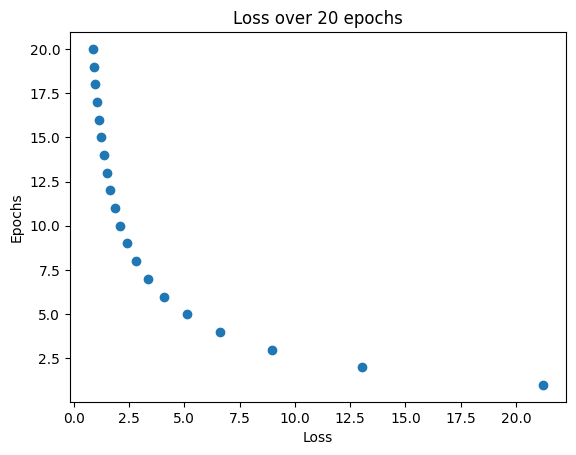

In [78]:
# we are going to plot the loss function over e_poch
import matplotlib.pyplot as plt

plt.scatter(x= loss_per_epoch, y= [x+1 for x in range(len(loss_per_epoch))])
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title('Loss over 20 epochs')

#### Generating Prediction

Now, we already optimized our model during training process. As we observe the iterate through our learning process, the average loss is going down.

Now, we will try to generate prediction on the ratings. Let's say we want to predict the rating on user 1 on item 1, here is the process :     
1. Get all parameters $bu,bi,pu,qi$.
2. Create prediction function.
3. Generate Prediction.

**Get all parameters $bu,bi,pu,qi$**

Parameter for user 1 and item 1

In [79]:
user1idx = user_to_id[1]
movie1idx = movie_to_id[1]

In [80]:
# bias
bu_1  = bu[user1idx]
bi_1 = bi[movie1idx]

# factor
pu_1 = pu[user1idx]
qi_1 = qi[movie1idx]

In [81]:
# prediction function
baseline_prediction = global_mean + bu_1 + bi_1

predicted_rating = baseline_prediction + (pu_1.dot(qi_1.T))
print('Predicted ratings on user 1 and item 1',predicted_rating)

Predicted ratings on user 1 and item 1 3.1253594631856325


Then, we compare prediction on the real rating.

In [82]:
rating_data.loc[(rating_data['userId']==1) & (rating_data['movieId']==1)]

,userId,movieId,rating
0,1,1,4.0


Yes, we already succeeded creating Funk SVD model from scratch, however we see that from beginning there are a lot of step involved during training process, so it's better to be more concise with **OOP** concept.

#### Object Oriented Code

In [83]:
# SVDClass
class FunkSVD() :

    def __init__(self,n_factors=50, n_epoch=20, lr=0.001, lambda_reg=0.002 ) -> None:
        """Initializes Model Hyperparameter / Configuration

        Parameters
        ----------
        n_factors : int
            Number of latent factor to use.
        n_epoch : int
            Number of iterations during model training (epochs)
        lr : float
            learning rate
        lamba_reg : float
            regularization strength for objective function / model parameter

        Returns
        -------
        -
        """
        self.n_factors = n_factors
        self.n_epoch = n_epoch
        self.lr = lr
        self.lambda_reg = lambda_reg

    def generate_mapping(self) :
        """Function to generate mapping on userId and itemId"""
        self.user_to_id = { user_id : idx for idx,user_id in
                                   enumerate(self.utility_matrix[self.user_column].unique())}

        self.id_to_user = { idx : user_id for idx,user_id in
                                   enumerate(self.utility_matrix[self.user_column].unique())}

        self.item_to_id = { item_id : idx for idx,item_id in
                                   enumerate(self.utility_matrix[self.item_column].unique())}

        self.id_to_item = { idx : item_id for idx,item_id in
                                   enumerate(self.utility_matrix[self.item_column].unique())}

    def initialize_parameters(self) :
        """Initializes biases and latent factor matrices.

        Parameters
        ----------
        n_users : int
            Number of unique users.
        n_items : int
            Number of unique items.
        n_factors : int
            Number of factors.

        Returns
        -------
        bu : numpy.array
            User biases vector.
        bi : numpy.array
            Item biases vector.
        pu : numpy.array
            User latent factors matrix.
        qi : numpy.array
            Item latent factors matrix.
        """
        bu = np.zeros(self.n_users)
        bi = np.zeros(self.n_items)

        pu = np.random.normal(0, .1, (self.n_users,self.n_factors))
        qi = np.random.normal(0, .1, (self.n_items,self.n_factors))

        return bu,bi,pu,qi

    def update_parameter(self,n_epoch,global_mean,bu,bi,pu,qi) :
        """
        Function to update parameter with gradient descent
        Parameters
        ----------
        n_epochs : int
            Number of epochs
        global_mean : float
            global mean for computing baseline prediction
        bu : numpy.array
            User biases vector.
        bi : numpy.array
            Item biases vector.
        pu : numpy.array
            User latent factors matrix.
        qi : numpy.array
            Item latent factors matrix.

        Returns
        -------
        bu : numpy.array
            Updated User biases vector.
        bi : numpy.array
            Updated Item biases vector.
        pu : numpy.array
            Updated User latent factors matrix.
        qi : numpy.array
            Updated Item latent factors matrix.
        loss_per_epoch : list
            Average loss per epoch
        """
        # copy parameter first to avoid overwriting
        bu = bu.copy()
        bi = bi.copy()
        pu = pu.copy()
        qi = qi.copy()

        # run update parameter
        loss_per_epoch = []
        for _ in range(n_epoch) :
            # add empty list to add avg loss per epoch
            avg_loss_training_samples = []
            # iterate all over training data
            for training_samples in self.utility_matrix :
                # extract userid, movieId, rating
                user = int(training_samples[0])
                item = int(training_samples[1])
                rating = training_samples[2]

                # get user idx
                user_idx = self.user_to_id[user]
                item_idx = self.item_to_id[item]
                # predict rating

                # slice each parameter
                b_user = bu[user_idx]
                b_item = bi[item_idx]
                p_user = pu[user_idx]
                q_item = qi[item_idx]

                # calculate baseline prediction
                baseline_prediction = global_mean + b_user + b_item

                predicted_rating = baseline_prediction + (p_user.dot(q_item.T))
                # calculate loss / objective
                loss = ((rating- predicted_rating)**2)/2 + (self.lambda_reg*(b_user + b_item + norm(p_user)**2 + norm(q_item)**2))/2

                # append loss
                avg_loss_training_samples.append(loss)

                # calculate gradient , dy / d(parameter)
                grad_user_bias = (rating-predicted_rating) - (self.lambda_reg * b_user)
                grad_item_bias = (rating-predicted_rating) - (self.lambda_reg * b_item)
                grad_user_factor = (rating-predicted_rating)* q_item - (self.lambda_reg * p_user)
                grad_item_factor = (rating-predicted_rating)* p_user - (self.lambda_reg * q_item)

                # update parameter
                bu[user_idx] += self.lr*grad_user_bias
                bi[item_idx] += self.lr*grad_item_bias
                pu[user_idx] += self.lr*grad_user_factor
                qi[item_idx] += self.lr*grad_item_factor
            avg_loss_training_samples = np.mean(avg_loss_training_samples)
            loss_per_epoch.append(avg_loss_training_samples)

        return bu,bi,pu,qi,loss_per_epoch

    def fit(self, utility_matrix, user_column, item_column, utility_column) :
        """
        Parameters :
        -----------
            utility_matrix (pd.DataFrame): _description_
            user_column (str): _description_
            item_column (str): _description_
            utility_column (str): _description_

        Returns :
        -----------
        self (object)
        """

        self.utility_matrix = utility_matrix
        self.user_column = user_column
        self.item_column = item_column
        self.utility_column = utility_column

        # setting position of column
        self.utility_matrix = self.utility_matrix[[self.user_column,self.item_column,self.utility_column]]
        # yield number of user
        self.n_users = self.utility_matrix[self.user_column].nunique()
        # yield number of items
        self.n_items = self.utility_matrix[self.item_column].nunique()

        # create id_mapping for user & item
        self.generate_mapping()

        # convert to numpy array
        self.utility_matrix = self.utility_matrix.to_numpy()


        # initialize parameters
        bu,bi,pu,qi = self.initialize_parameters()

        # extract global mean
        self.global_mean = self.utility_matrix[:,2].mean()

        # update parameters
        bu_updated, bi_updated, pu_updated,qi_updated,loss = self.update_parameter(n_epoch = self.n_epoch,
                                                                                    global_mean = self.global_mean,
                                                                                    bu= bu, bi= bi, pu= pu, qi= qi)

        # set updated parameter as part of object
        self.bu = bu_updated
        self.bi = bi_updated
        self.pu = pu_updated
        self.qi = qi_updated

    def predict_rating(self,user,item) :
        """


        Parameters :
        -----------
            utility_matrix (pd.DataFrame): _description_
            user_column (str): _description_
            item_column (str): _description_
            utility_column (str): _description_

        Returns :
        -----------
        self (object)
        """

        # get user idx
        user_idx = self.user_to_id[user]
        item_idx = self.item_to_id[item]
        # predict rating

        # slice each parameter
        b_user = self.bu[user_idx]
        b_item = self.bi[item_idx]
        p_user = self.pu[user_idx]
        q_item = self.qi[item_idx]

        # calculate baseline prediction
        baseline_prediction = self.global_mean + b_user + b_item
        predicted_rating = baseline_prediction + (p_user.dot(q_item.T))

        return predicted_rating

In [84]:
model = FunkSVD()

model.fit(utility_matrix= rating_data, 
          user_column='userId',
          item_column= 'movieId',
          utility_column= 'rating')

Try to generate prediction user 1 and item 1.

In [85]:
model.predict_rating(user=1,item=1)

4.337298678956544

______

## Train Recommender System Models

**Note on Surprise Library**

To model the personalized RecSys, we will use a well-defined library called with `surprise`. See the [Surprise Docs.](https://surprise.readthedocs.io/en/stable/index.html)

In [86]:
# Uncomment to install the package
# import surprise

### Load the Data

Why we do this **again**? Because we works on a specific library that need specific input format.

In [87]:
# Import some library
from surprise import Dataset, Reader

Initiate the rating scale

In [88]:
reader = Reader(rating_scale = (1, 5))
reader

Initiate the data. It must be on format `userId`, `itemId`, and `ratings` respectively.

In [89]:
utility_data = Dataset.load_from_df(
                    df = rating_data[['userId', 'movieId', 'rating']].copy(),
                    reader = reader
)

utility_data

In [90]:
utility_data.df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,70,3.0


In [91]:
rating_data.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,70,3.0


### Split Train-Test

We then split the train-test data. We use the similar logic from previous section.

In [92]:
# Load library for deep copy
import copy

In [93]:
# Create a function
def train_test_split(utility_data, test_size, random_state):
    """
    Train test split the data
    ref: https://surprise.readthedocs.io/en/stable/FAQ.html#split-data-for-unbiased-estimation-py

    Parameters
    ----------
    utility_data : Surprise utility data
        The sample of whole data set

    test_size : float, default=0.2
        The test size

    random_state : int, default=42
        For reproducibility

    Returns
    -------
    full_data : Surprise utility data
        The new utility data

    train_data : Surprise format
        The train data

    test_data : Surprise format
        The test data
    """
    # Deep copy the utility_data
    full_data = copy.deepcopy(utility_data)

    # Generate random seed
    np.random.seed(random_state)

    # Shuffle the raw_ratings for reproducibility
    raw_ratings = full_data.raw_ratings
    np.random.shuffle(raw_ratings)

    # Define the threshold
    threshold = int((1-test_size) * len(raw_ratings))

    # Split the data
    train_raw_ratings = raw_ratings[:threshold]
    test_raw_ratings = raw_ratings[threshold:]

    # Get the data
    full_data.raw_ratings = train_raw_ratings
    train_data = full_data.build_full_trainset()
    test_data = full_data.construct_testset(test_raw_ratings)

    return full_data, train_data, test_data

In [94]:
# Split the data
full_data, train_data, test_data = train_test_split(
    utility_data,
    test_size = 0.2,
    random_state = 42)

# Validate the splitting
train_data.n_ratings, len(test_data)

(16608, 4152)

### Create the Model

### Experimentation

We want to train all model candidate with its hyperparameter so that we can compare which model + settings yield the better result.

![title](../assets/config_params.png)

Since *Hyperparameter* is not yielded through learning process, we have to find it/set it manually to yield optimal model performance.

Some methods of Hyperparameter Tunings :    

- GridSearchCV
  Fitting model through all combinations of hyperparameter values and compare each fit → which combinations yield the best objective

- RandomizedSearchCV
  Fitting Model only through sampled hyperparameter candidates. Much more efficient than GridSearchCV

Hyperparameter Tuning require **Cross Validation** , making sure the during hyperparameter selection the performance measured is unbias.

<center><h2/>Cross Validation</center>
<center> <img src="../assets/cross_validation.png" width=800> </center>
<center><a href="https://scikit-learn.org/stable/modules/cross_validation.html">Source</a></center>


**Hyperparameter** in best models
to identify the hyperparameters in models, we need to read its documentation/ paper first. For **surprise** models, the documentation is [here](https://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline)
Hyperparameters :    

- *k* (Number of Neigbors)
- similarity function

**Cross Validation** Method

for this we will choose the **K-Fold** Cross Validation

**Hyperparameter Method** : *RandomizedSearchCV*
Due to high computational cost if we use *GridSearchCV* we we will use *RandomizedSearchCV* .

To run hyperparameter tuning, **surprise** package already have builtin function to run hyperparameter tuning.

**Model Candidate**

1. Baseline Model (Mean Prediction)  (does not have hyperparameter).
2. Funk SVD (Not SVD).

In [95]:
# import Random Search CV
from surprise.model_selection.search import RandomizedSearchCV

# Load the model library
# i.e. Baseline, SVD
from surprise import AlgoBase, SVD

Our Baseline Model just simply predict ratingss using mean from all training data provided to the model.
Since `surprise` library does not provide mean prediction model, we have to create custom algorithm first.
Guide `https://surprise.readthedocs.io/en/stable/building_custom_algo.html`

In [96]:
class MeanPrediction(AlgoBase):
    '''Baseline prediction. Return global mean as prediction'''
    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        '''Fit the train data'''
        AlgoBase.fit(self, trainset)

    def estimate(self, u, i):
        '''Perform the estimation/prediction.'''
        est = self.trainset.global_mean
        return est

**Train Baseline Model**

Since our baseline model does not have hyperparameters, we will only cross validate the model.

In [97]:
# Creating baseline model instance
model_baseline = MeanPrediction()
model_baseline

In [98]:
# Import the cross validation module
from surprise.model_selection import cross_validate

To perform cross validate
`cross_validate(algo, data, cv, measures)`

1. `algo` = Surprise model
2. `data` = Surprise format data
3. `cv` = number of fold of cross validation
4. `measures` = metric to measure model performance



In [99]:
# Use full_data for cross validation
# Your results could be different because
# there is no random seed stated within this functions
cv_baseline = cross_validate(algo = model_baseline,
                             data = full_data,
                             cv = 5,
                             measures = ['rmse'])

In [100]:
# Extract CV results
cv_baseline_rmse = cv_baseline['test_rmse'].mean()
cv_baseline_rmse

0.9981481819368682

To perform RandomizedSearchCV, `RandomizedSearchCV(algo_class, param_distributions,cv)`
- **algo_class** : surprise model class, in our case, we are using **KNNBaseline** class, so algo_class=KNNBaseline.
- **param_distributions** :  dictionary containing param grid, the values should be in `list`.
- **cv** : number of fold to split, commonly 5.

**Train SVD Model**

Hyperparameter that are in Funk SVD models are :     
- $\gamma$ : Learning Rate
- n_factors : Number of letent factor
- $\lambda$ : Regularization strength

Hyperparameter Candidate :     
1. Learning Rate ($\gamma$)

For this experiment we will try several values

[1,0.1,0.01,0.001,0.0001]

2. Number of latent factors
For this experiment we will try some values :    

[50,100,200]

3. Regularization Strength

[1,0.1,0.01,0.02]


In [102]:
#create dictionary of parameter
params_SVD = {'lr_all' : [1,0.1,0.01,0.001,0.0001], 
              'n_factors' : [50,100,200],
              'reg_all' : [1,0.1,0.01,0.02]
}

In [103]:
tuning_svd = RandomizedSearchCV(algo_class=SVD, 
                                param_distributions = params_SVD,
                                cv=5
)

In [104]:
tuning_svd.fit(data=full_data)

**Performance comparison**

We can summarize the performance as follow

In [106]:
summary_df = pd.DataFrame({
    'Model': 
        ['Baseline', 'Funk SVD'], 
    'CV Performance - RMSE': 
        [cv_baseline_rmse,tuning_svd.best_score['rmse'] ],
    'Model Condiguration':
        ['N/A',f'{tuning_svd.best_params["rmse"]}']})

summary_df

,Model,CV Performance - RMSE,Model Condiguration
0,Baseline,0.998148,N/A
1,Funk SVD,0.841329,"{'lr_all': 0.01, 'n_factors': 50, 'reg_all': 0.1}"


**Best Hyperparameter Combination**

In [107]:
tuning_svd.best_params

{'rmse': {'lr_all': 0.01, 'n_factors': 50, 'reg_all': 0.1},
 'mae': {'lr_all': 0.01, 'n_factors': 50, 'reg_all': 0.1}}

Finally, we retrain the best model with tuned parameters

In [108]:
best_params_svd = tuning_svd.best_params['rmse']

In [112]:
# Create object
model_best = SVD(**best_params_svd)

# Retrain on whole train dataset
model_best.fit(train_data)

### Evaluate the Best Model

#### Evaluating RMSE

After finding the best model, we can perform sanity check regarding the performance on the test dataset.

In [109]:
# import performance library
from surprise import accuracy

Next step, we predict the test set using our best model

In [ ]:
test_pred = model_best.test(test_data)
test_rmse = accuracy.rmse(test_pred)

test_rmse

RMSE: 0.8256


0.8255889489714877

To summarize

In [114]:
summary_test_df = pd.DataFrame({
    'Model' : ['User to User CF'],
    'RMSE-Tuning': [tuning_svd.best_score['rmse']],
    'RMSE-Test': [test_rmse]})

summary_test_df

,Model,RMSE-Tuning,RMSE-Test
0,User to User CF,0.841329,0.825589


Now, the model can yield the better (if not great) predictions.

___________________

# **3.Predictions / Generating Recommendation**

Decision Process is to recommend items to the users
from our trained model.

<image src="https://www.mdpi.com/applsci/applsci-10-05510/article_deploy/html/images/applsci-10-05510-g001.png" image>

1. User to User Collaborative Filtering
  We already trained our best model on full dataset, now its time to utilize our model to generate recommendations.

How do we generate recommendation ?


To generate recommendation :
- Predict all movies or only unseen movies rating from given users.
- Followed by ordering the movies by its predicted ratings.

## Predict with Best Model : User to User Collaborative Filtering

In [115]:
# Recommendation based on Best Models
# We will try to recommend on sample userid ,userId 1 & 99

# We can use model_best.predict method
help(model_best.predict)

Help on method predict in module surprise.prediction_algorithms.algo_base:

predict(uid, iid, r_ui=None, clip=True, verbose=False) method of surprise.prediction_algorithms.matrix_factorization.SVD instance
    Compute the rating prediction for given user and item.
    
    The ``predict`` method converts raw ids to inner ids and then calls the
    ``estimate`` method which is defined in every derived class. If the
    prediction is impossible (e.g. because the user and/or the item is
    unknown), the prediction is set according to
    :meth:`default_prediction()
    <surprise.prediction_algorithms.algo_base.AlgoBase.default_prediction>`.
    
    Args:
        uid: (Raw) id of the user. See :ref:`this note<raw_inner_note>`.
        iid: (Raw) id of the item. See :ref:`this note<raw_inner_note>`.
        r_ui(float): The true rating :math:`r_{ui}`. Optional, default is
            ``None``.
        clip(bool): Whether to clip the estimation into the rating scale.
            For exampl

`model_best.predict` has arguments
- `uid` (i.e., the `userId`) and
- `iid` (i.e., the item ID or `movieId`)

### Let's predict what is the rating of user 9 to movie 10

In [116]:
sample_prediction = model_best.predict(uid = 9,
                                       iid = 10)

In [117]:
sample_prediction

Prediction(uid=9, iid=10, r_ui=None, est=4.201534621070885, details={'was_impossible': False})

The results tell us that :
- `r_ui` : actual rating --> `None`, means user 9 have yet rated movie 10
- `est` : the estimated rating from our model
- `details` : whether prediction is impossible or not. So it's possible to predict.

### Let's predict all the unseen/unrated movie by userId 9

**First, we find the unrated movie id from user id 9**

In [118]:
# Get unique movieId
unique_movie_id = set(rating_data['movieId'])
print(unique_movie_id)

{54272, 1, 3, 1028, 6, 2567, 520, 2571, 1036, 54286, 527, 152081, 2078, 32, 2081, 34, 1060, 1573, 39, 3623, 3624, 3114, 33836, 47, 1584, 1073, 56367, 1586, 48, 3633, 3638, 1080, 2105, 2115, 2628, 69, 70, 1608, 1097, 586, 3147, 588, 589, 590, 587, 592, 593, 1617, 2640, 8783, 597, 2642, 3671, 3160, 3157, 26712, 41566, 608, 2657, 30816, 48738, 104, 110, 2671, 1136, 2160, 631, 2683, 4226, 5254, 1682, 150, 153, 1690, 108190, 44191, 44195, 165, 44199, 1704, 1196, 38061, 1198, 1203, 1204, 3253, 160438, 50872, 185, 1210, 186, 1722, 3256, 1214, 1726, 7361, 1220, 3268, 106696, 1225, 2762, 2248, 1230, 2770, 4306, 33493, 1240, 6874, 2268, 6365, 1246, 1247, 736, 1245, 1250, 227, 737, 5349, 6373, 2791, 235, 1259, 33004, 750, 1777, 1266, 3825, 2804, 1269, 1270, 2294, 1784, 3826, 252, 1278, 2302, 34048, 5378, 111362, 260, 780, 60684, 7438, 5903, 781, 2321, 4369, 786, 34072, 4890, 1307, 4896, 7458, 292, 296, 5418, 300, 76077, 7981, 2355, 1333, 3897, 316, 318, 2371, 5445, 329, 32587, 3916, 333, 1356, 13

In [121]:
# Get movieId that is rated by user id 9
rated_movie_id = set(rating_data.loc[rating_data['userId']==9, 'movieId'])
print(rated_movie_id)

{5378, 5445, 5481, 1198, 1270}


In [122]:
# Find unrated movieId
# Use set operation
# unrateddId = wholeId - ratedId
unrated_movie_id = unique_movie_id.difference(rated_movie_id)
print(unrated_movie_id)

{54272, 1, 3, 1028, 6, 2567, 520, 2571, 1036, 54286, 527, 152081, 2078, 32, 2081, 34, 1060, 1573, 39, 3623, 3624, 3114, 33836, 47, 1584, 1073, 56367, 1586, 48, 3633, 3638, 1080, 2105, 2115, 2628, 69, 70, 1608, 1097, 586, 3147, 588, 589, 590, 587, 592, 593, 1617, 2640, 8783, 597, 2642, 3671, 3160, 3157, 26712, 41566, 608, 2657, 30816, 48738, 104, 110, 2671, 1136, 2160, 631, 2683, 4226, 5254, 1682, 150, 153, 1690, 108190, 44191, 44195, 165, 44199, 1704, 1196, 38061, 1203, 1204, 3253, 160438, 50872, 185, 1210, 186, 1722, 3256, 1214, 1726, 7361, 1220, 3268, 106696, 1225, 2762, 2248, 1230, 2770, 4306, 33493, 1240, 6874, 2268, 6365, 1246, 1247, 736, 1245, 1250, 227, 737, 5349, 6373, 2791, 235, 1259, 33004, 750, 1777, 1266, 3825, 2804, 1269, 2294, 1784, 3826, 252, 1278, 2302, 34048, 111362, 260, 780, 60684, 7438, 5903, 781, 2321, 4369, 786, 34072, 4890, 1307, 4896, 7458, 292, 296, 5418, 300, 76077, 7981, 2355, 1333, 3897, 316, 318, 2371, 329, 32587, 3916, 333, 1356, 1359, 852, 51540, 103253, 

In [123]:
# Let's create a function
def get_unrated_item(userid, rating_data):
    """
    Get unrated item id from a user id

    Parameters
    ----------
    userid : int
        The user id

    rating_data : pandas DataFrame
        The rating data

    Returns
    -------
    unrated_item_id : set
        The unrated item id
    """
    # Find the whole item id
    unique_item_id = set(rating_data['movieId'])

    # Find the item id that was rated by user id
    rated_item_id = set(rating_data.loc[rating_data['userId']==userid, 'movieId'])

    # Find the unrated item id
    unrated_item_id = unique_item_id.difference(rated_item_id)

    return unrated_item_id


In [124]:
unrated_movie_id = get_unrated_item(
    userid=9, 
    rating_data=rating_data)

print(unrated_movie_id)

{54272, 1, 3, 1028, 6, 2567, 520, 2571, 1036, 54286, 527, 152081, 2078, 32, 2081, 34, 1060, 1573, 39, 3623, 3624, 3114, 33836, 47, 1584, 1073, 56367, 1586, 48, 3633, 3638, 1080, 2105, 2115, 2628, 69, 70, 1608, 1097, 586, 3147, 588, 589, 590, 587, 592, 593, 1617, 2640, 8783, 597, 2642, 3671, 3160, 3157, 26712, 41566, 608, 2657, 30816, 48738, 104, 110, 2671, 1136, 2160, 631, 2683, 4226, 5254, 1682, 150, 153, 1690, 108190, 44191, 44195, 165, 44199, 1704, 1196, 38061, 1203, 1204, 3253, 160438, 50872, 185, 1210, 186, 1722, 3256, 1214, 1726, 7361, 1220, 3268, 106696, 1225, 2762, 2248, 1230, 2770, 4306, 33493, 1240, 6874, 2268, 6365, 1246, 1247, 736, 1245, 1250, 227, 737, 5349, 6373, 2791, 235, 1259, 33004, 750, 1777, 1266, 3825, 2804, 1269, 2294, 1784, 3826, 252, 1278, 2302, 34048, 111362, 260, 780, 60684, 7438, 5903, 781, 2321, 4369, 786, 34072, 4890, 1307, 4896, 7458, 292, 296, 5418, 300, 76077, 7981, 2355, 1333, 3897, 316, 318, 2371, 329, 32587, 3916, 333, 1356, 1359, 852, 51540, 103253, 

**Then, we create the prediction from the unrated movie**

In [125]:
# Initialize dict
predicted_unrated_movie = {
    'userId': 9,
    'movieId': [],
    'predicted_rating': []
}

predicted_unrated_movie

{'userId': 9, 'movieId': [], 'predicted_rating': []}

In [126]:
# Loop for over all unrated movie Id
for id in unrated_movie_id:
    # Create a prediction
    pred_id = model_best.predict(uid = predicted_unrated_movie['userId'],
                                 iid = id)

    # Append
    predicted_unrated_movie['movieId'].append(id)
    predicted_unrated_movie['predicted_rating'].append(pred_id.est)

In [127]:
# Convert to dataframe
predicted_unrated_movie = pd.DataFrame(predicted_unrated_movie)
predicted_unrated_movie

,userId,movieId,predicted_rating
0,9,54272,4.103527
1,9,1,4.403096
2,9,3,3.718131
3,9,1028,4.283774
4,9,6,4.218377
...,...,...,...
238,9,91630,4.350271
239,9,7153,4.647837
240,9,1527,4.146413
241,9,3578,4.366002


In [128]:
# Sort the predicted rating values
predicted_unrated_movie = predicted_unrated_movie.sort_values('predicted_rating', ascending=False)

predicted_unrated_movie

,userId,movieId,predicted_rating
160,9,318,4.910305
122,9,750,4.854482
196,9,904,4.806627
83,9,1204,4.788168
203,9,2959,4.765678
...,...,...,...
96,9,3268,3.007112
219,9,435,2.963187
242,9,1021,2.936779
130,9,3826,2.787664


In [129]:
# Let's create this into a function
def get_pred_unrated_item(userid, estimator, unrated_item_id):
    """
    Get the predicted unrated item id from user id

    Parameters
    ----------
    userid : int
        The user id

    estimator : Surprise object
        The estimator

    unrated_item_id : set
        The unrated item id

    Returns
    -------
    pred_data : pandas Dataframe
        The predicted rating of unrated item of user id
    """
    # Initialize dict
    pred_dict = {
        'userId': userid,
        'movieId': [],
        'predicted_rating': []
    }

    # Loop for over all unrated movie Id
    for id in unrated_item_id:
        # Create a prediction
        pred_id = estimator.predict(uid = pred_dict['userId'],
                                    iid = id)

        # Append
        pred_dict['movieId'].append(id)
        pred_dict['predicted_rating'].append(pred_id.est)

    # Create a dataframe
    pred_data = pd.DataFrame(pred_dict).sort_values('predicted_rating',
                                                     ascending = False)

    return pred_data

In [131]:
predicted_unrated_movie = get_pred_unrated_item(
    userid=9,
    estimator=model_best,
    unrated_item_id=unrated_movie_id)

predicted_unrated_movie

,userId,movieId,predicted_rating
160,9,318,4.910305
122,9,750,4.854482
196,9,904,4.806627
83,9,1204,4.788168
203,9,2959,4.765678
...,...,...,...
96,9,3268,3.007112
219,9,435,2.963187
242,9,1021,2.936779
130,9,3826,2.787664


And then we create the top movie predictions.

It's nice, but we do not know what movie on each `movieId`. We need to extract the movie title for each `movieId`

In [ ]:
def load_movie_data(movie_path):
    """
    Load movie data from the given path

    Parameters
    ----------
    movie_path : str
        The movie data path

    Returns
    -------
    movie_data : pandas DataFrame
        The movie metadata
    """
    # Load data
    movie_data = pd.read_csv(movie_path,
                             index_col='movieId',
                             delimiter=',')
    print('Movie data shape :', movie_data.shape)
    
    return movie_data

In [133]:
# Define the movie path
movie_path = '../data/movies.csv'

In [134]:
# Load movie data using upper function
movie_data = load_movie_data(movie_path = movie_path)

movie_data.head()

Movie data shape : (9742, 2)


,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [135]:
# Pick top k biggest rating
k = 5
top_movies = predicted_unrated_movie.head(k).copy()
top_movies

,userId,movieId,predicted_rating
160,9,318,4.910305
122,9,750,4.854482
196,9,904,4.806627
83,9,1204,4.788168
203,9,2959,4.765678


Finally, we can add the Movie Title

In [136]:
# Add the movie title
top_movies['title'] = movie_data.loc[top_movies['movieId'], 'title'].values
top_movies['genres'] = movie_data.loc[top_movies['movieId'], 'genres'].values

top_movies

,userId,movieId,predicted_rating,title,genres
160,9,318,4.910305,"Shawshank Redemption, The (1994)",Crime|Drama
122,9,750,4.854482,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
196,9,904,4.806627,Rear Window (1954),Mystery|Thriller
83,9,1204,4.788168,Lawrence of Arabia (1962),Adventure|Drama|War
203,9,2959,4.765678,Fight Club (1999),Action|Crime|Drama|Thriller


In [137]:
# Wrapping to a function
def get_top_highest_unrated(estimator, k, userid, rating_data, movie_data):
    """
    Get top k highest of unrated movie from a Surprise estimator RecSys

    Parameters
    ----------
    estimator : Surprise model
        The RecSys model

    k : int
        The number of Recommendations

    userid : int
        The user Id to recommend

    rating_data : pandas Data Frame
        The rating data

    movie_data : pandas DataFrame
        The movie meta data

    Returns
    -------
    top_item_pred : pandas DataFrame
        The top items recommendations
    """
    # 1. Get the unrated item id of a user id
    unrated_item_id = get_unrated_item(userid=userid, rating_data=rating_data)

    # 2. Create prediction from estimator to all unrated item id
    predicted_unrated_item = get_pred_unrated_item(userid = userid,
                                                   estimator = estimator,
                                                   unrated_item_id = unrated_item_id)

    # 3. Sort & add meta data
    top_item_pred = predicted_unrated_item.head(k).copy()
    top_item_pred['title'] = movie_data.loc[top_item_pred['movieId'], 'title'].values
    top_item_pred['genres'] = movie_data.loc[top_item_pred['movieId'], 'genres'].values

    return top_item_pred


In [138]:
# Generate 10 recommendation for user 100
get_top_highest_unrated(estimator=model_best,
                        k=10,
                        userid=100,
                        rating_data=rating_data,
                        movie_data=movie_data)

,userId,movieId,predicted_rating,title,genres
74,100,1204,4.361884,Lawrence of Arabia (1962),Adventure|Drama|War
108,100,750,4.328687,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
141,100,318,4.310110,"Shawshank Redemption, The (1994)",Crime|Drama
168,100,4973,4.292716,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance
136,100,7981,4.254229,Infernal Affairs (Mou gaan dou) (2002),Crime|Drama|Thriller
85,100,7361,4.221137,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi
172,100,904,4.217677,Rear Window (1954),Mystery|Thriller
57,100,2160,4.212454,Rosemary's Baby (1968),Drama|Horror|Thriller
179,100,2959,4.208106,Fight Club (1999),Action|Crime|Drama|Thriller
100,100,1250,4.176682,"Bridge on the River Kwai, The (1957)",Adventure|Drama|War


In [139]:
# Generate 10 recommendation for user 500
get_top_highest_unrated(estimator=model_best,
                        k=10,
                        userid=500,
                        rating_data=rating_data,
                        movie_data=movie_data)

,userId,movieId,predicted_rating,title,genres
111,500,750,3.827555,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
174,500,4973,3.784271,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance
84,500,7361,3.734619,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi
146,500,318,3.732327,"Shawshank Redemption, The (1994)",Crime|Drama
181,500,904,3.722679,Rear Window (1954),Mystery|Thriller
56,500,2160,3.706901,Rosemary's Baby (1968),Drama|Horror|Thriller
74,500,1204,3.705719,Lawrence of Arabia (1962),Adventure|Drama|War
50,500,608,3.681407,Fargo (1996),Comedy|Crime|Drama|Thriller
66,500,44195,3.657933,Thank You for Smoking (2006),Comedy|Drama
160,500,858,3.655964,"Godfather, The (1972)",Crime|Drama
